In [1]:
# !pip install duckdb
# !pip install psycopg2

In [2]:
import numpy as np
import pandas as pd
import duckdb
import psycopg2
import matplotlib.pyplot as plt

In [3]:
try:
    psql_conn = psycopg2.connect("dbname='ian_database' user='ian' host='localhost' password='1234'")
    print("Connected to the database successfully.")
except Exception as e:
    print(f"Error connecting to the database: {e}")

Connected to the database successfully.


In [4]:
file_path = './COMPANY_data.xlsx'
all_sheets = pd.read_excel(file_path, sheet_name=None)  # 讀取所有工作表

# 打印所有工作表名稱
print("Available sheets:", all_sheets.keys())
print(f"Total number of sheets: {len(all_sheets)}")  # 打印工作表的總數量


# 查看特定工作表的數據
for sheet_name, data_frame in all_sheets.items():  # 遍歷 all_sheets 而不是 df
    print(f"\nData from sheet: {sheet_name}")
    print(data_frame.head())  # 打印每個工作表的前幾行數據
    print(type(data_frame))   # 確認每個工作表是否為 DataFrame


Available sheets: dict_keys(['EMPLOYEE', 'DEPARTMENT', 'DEPT_LOCATIONS', 'WORKS_ON', 'PROJECT', 'DEPENDENT'])
Total number of sheets: 6

Data from sheet: EMPLOYEE
      Fname Minit    Lname        Ssn      Bdate                   Address  \
0      John     B    Smith  123456789 1965-01-09  731 Fondren, Houston, TX   
1  Franklin     T     Wong  333445555 1955-12-08     638 Voss, Houston, TX   
2    Alicia     J   Zelaya  999887777 1968-01-19   3321 Castle, Spring, TX   
3  Jennifer     S  Wallace  987654321 1941-06-20   291 Berry, Bellaire, TX   
4    Ramesh     K  Narayan  666884444 1962-09-15  975 Fire Oak, Humble, TX   

  Sex  Salary    Super_ssn  Dno  
0   M   30000  333445555.0    5  
1   M   40000  888665555.0    5  
2   F   25000  987654321.0    4  
3   F   43000  888665555.0    4  
4   M   38000  333445555.0    5  
<class 'pandas.core.frame.DataFrame'>

Data from sheet: DEPARTMENT
            Dname  Dnumber    Mgr_ssn Mgr_start_date
0        Research        5  333445555     19

In [5]:
# 查看每個表的列格式
for sheet_name, data_frame in all_sheets.items():  # 使用 all_sheets 來遍歷
    print(f"Sheet: {sheet_name}")
    print(data_frame.dtypes)  # 查看每個表的列格式

Sheet: EMPLOYEE
Fname                object
Minit                object
Lname                object
Ssn                   int64
Bdate        datetime64[ns]
Address              object
Sex                  object
Salary                int64
Super_ssn           float64
Dno                   int64
dtype: object
Sheet: DEPARTMENT
Dname                     object
Dnumber                    int64
Mgr_ssn                    int64
Mgr_start_date    datetime64[ns]
dtype: object
Sheet: DEPT_LOCATIONS
Dnumber       int64
Dlocation    object
dtype: object
Sheet: WORKS_ON
Essn       int64
Pno        int64
Hours    float64
dtype: object
Sheet: PROJECT
Pname        object
Pnumber       int64
Plocation    object
Dnum          int64
dtype: object
Sheet: DEPENDENT
Essn                       int64
Dependent_name            object
Sex                       object
Bdate             datetime64[ns]
Relationship              object
dtype: object


In [6]:
con = duckdb.connect()

# 註冊所有工作表到 DuckDB
for sheet_name, data_frame in all_sheets.items():  # 使用 all_sheets 而不是 df
    # 檢查是否為 Series，如果是，轉換為 DataFrame
    if isinstance(data_frame, pd.Series):
        data_frame = data_frame.to_frame()
        print(data_frame)

    # 將 DataFrame 註冊到 DuckDB
    con.register(sheet_name, data_frame)

# 打印已經註冊的表名稱
print("Tables registered in DuckDB:", all_sheets.keys())


Tables registered in DuckDB: dict_keys(['EMPLOYEE', 'DEPARTMENT', 'DEPT_LOCATIONS', 'WORKS_ON', 'PROJECT', 'DEPENDENT'])


In [7]:
def query(query):
    result = con.execute(query).fetchall()
    column_names = [desc[0] for desc in con.description]
    return column_names, result

# 第一題
<font size='4'>
上課時多次使用的 COMPANY 資料庫的資料，被放在 COOL 的「頁
面」中的 XLSX 檔和 PostgreSQL 資料庫備份檔（兩個檔案中裝有同一份資料）。針對這
個資料庫，請幫以下任務撰寫合適的 SQL 指令，每題一個，並附上針對附件的資料執行
該指令後得到的查詢結果。
</font>

## (a)
<font size='3'> 
針對公司裡所有在跨越兩個以上地點的部門工作的每一位職員，列出他的 SSN、生
日，以及他登記在公司的親屬人數。
</font>

In [8]:
# 假設你已經連接到 DuckDB 並且 con 是 DuckDB 的連接對象

# 定義要執行的查詢
sql_query = """
SELECT 
    E.Ssn, 
    E.Bdate, 
    COUNT(DISTINCT DEP.Dependent_name) AS dependent_count
FROM 
    EMPLOYEE E
JOIN 
    DEPARTMENT D ON E.Dno = D.Dnumber  -- 連接部門
JOIN 
    DEPT_LOCATIONS DL ON D.Dnumber = DL.Dnumber  -- 連接部門與位置
LEFT JOIN 
    DEPENDENT DEP ON E.Ssn = DEP.Essn  -- 連接員工與親屬
GROUP BY 
    E.Ssn, E.Bdate
HAVING 
    COUNT(DISTINCT DL.Dlocation) > 1  -- 選擇在兩個或以上地點工作的部門的員工
ORDER BY
    E.Ssn;
"""

# 使用 query 函數執行查詢
column_names, results = query(sql_query)

# 打印列名
print("Column Names:", column_names)

df_result = pd.DataFrame(results, columns=column_names)

# 將 Bdate 列轉換為日期格式
df_result['Bdate'] = pd.to_datetime(df_result['Bdate']).dt.date

# 打印結果
print(df_result)
print(df_result.to_latex(index=False))


Column Names: ['Ssn', 'Bdate', 'dependent_count']
         Ssn       Bdate  dependent_count
0  123456789  1965-01-09                3
1  333445555  1955-12-08                3
2  453453453  1972-07-31                0
3  666884444  1962-09-15                0
\begin{tabular}{rlr}
\toprule
Ssn & Bdate & dependent_count \\
\midrule
123456789 & 1965-01-09 & 3 \\
333445555 & 1955-12-08 & 3 \\
453453453 & 1972-07-31 & 0 \\
666884444 & 1962-09-15 & 0 \\
\bottomrule
\end{tabular}



## (b)
<font size='3'> 
針對公司裡有複數位員工的每一個部門，列出其部門編號、部門名稱、部門內所有
員工到 2024/10/1 為止的平均年齡（算實歲且無條件捨去到整數位，例如 2022/10/2
出生的人是 1 歲、2022/10/1 出生的人是 2 歲）。
</font>

In [9]:
sql_query = """
WITH employee_age AS (
    SELECT
        e.dno,
        e.bdate,
        FLOOR((DATE '2024-10-01' - e.bdate) / 365) AS age
    FROM employee e
)
SELECT
    d.dnumber,
    d.dname,
    FLOOR(AVG(ea.age)) AS avg_age
FROM department d
JOIN employee_age ea ON d.dnumber = ea.dno
GROUP BY d.dnumber, d.dname
HAVING COUNT(ea.bdate) > 1
ORDER BY d.dnumber
"""


# 使用 query 函數執行查詢
column_names, results = query(sql_query)

# 打印列名
print("Column Names:", column_names)

# 將結果轉換為 DataFrame 並打印
df_result = pd.DataFrame(results, columns=column_names)
print(df_result)

# 將結果轉換為 LaTeX 格式並打印
print(df_result.to_latex(index=False))


Column Names: ['Department_Number', 'Department_Name', 'Average_Age']
   Department_Number Department_Name  Average_Age
0                  5        Research         60.0
1                  4  Administration         64.0
\begin{tabular}{rlr}
\toprule
Department_Number & Department_Name & Average_Age \\
\midrule
5 & Research & 60.000000 \\
4 & Administration & 64.000000 \\
\bottomrule
\end{tabular}



## (c)
<font size='3'>針對公司裡參與人數第二多的專案，列出其專案編號、專案名稱、專案參與人的在該專案的平均工時。如果有 n 個專案的參與人數都是第二多，你的搜尋結果就應該有 n 筆資料。在找「第二多」的時候，假設有數個專案的參與人數並列第一多，則那些專案都算排名第一，而非只有其中一個是第一。舉例來說，如果專案有五個，分別是 A、B、C、D、E，其參與人數分別是 10、8、10、12、12，則人數排名第二的專案是 A 和 C，既不是 D 也不是 E。<br>特別說明：針對這一小題，我們推薦大家使用 LIMIT 和 OFFSET 語法，例 如LIMIT 1 OFFSET 1 這樣。建議大家自行上網學習如何使用這些語法，然後在這一題中試試看！</font>

In [78]:
sql_query = """
WITH project_participation AS (
    SELECT
        p.pnumber,
        p.pname,
        COUNT(w.essn) AS participant_count,
        AVG(w.hours) AS avg_hours
    FROM project p
    JOIN works_on w ON p.pnumber = w.pno
    WHERE w.hours IS NOT NULL
    GROUP BY p.pnumber, p.pname
)
SELECT pnumber, pname, avg_hours
FROM project_participation
WHERE 
    participant_count = (
        SELECT participant_count
        FROM project_participation
        GROUP BY participant_count
        ORDER BY participant_count DESC
        LIMIT 1 OFFSET 1
    );
"""

column_names, results = query(sql_query)

# 打印列名
print("Column Names:", column_names)

# 將結果轉換為 DataFrame 並打印
df_result = pd.DataFrame(results, columns=column_names)
print(df_result)

# 將結果轉換為 LaTeX 格式並打印
print(df_result.to_latex(index=False))


Column Names: ['Pnumber', 'Pname', 'avg_hours']
   Pnumber           Pname  avg_hours
0        1        ProductX      26.25
1        3        ProductZ      25.00
2       20  Reorganization      12.50
\begin{tabular}{rlr}
\toprule
Pnumber & Pname & avg_hours \\
\midrule
1 & ProductX & 26.250000 \\
3 & ProductZ & 25.000000 \\
20 & Reorganization & 12.500000 \\
\bottomrule
\end{tabular}



## (d)
<font size='3'>
針對公司裡有參與任何一個「參與人數第二多的專案」（定義如前一小題）的所有員工，列出他們的 SSN、姓氏、薪資是否達到 40000、所屬部門主管的 SSN、所屬部門主管的姓氏。針對第三個欄位，如果有達到（大於等於）則記錄為「yes」，否則則記錄為「no」。
</font>

In [11]:
sql_query = """
WITH ProjectParticipation AS (
    SELECT 
        P.Pnumber AS Project_Number,
        P.Pname AS Project_Name,
        COUNT(W.Essn) AS Participant_Count,  -- 计算每个项目的参与人数
        AVG(W.Hours) AS Average_Hours         -- 计算每个项目的平均工时
    FROM 
        PROJECT P
    LEFT JOIN 
        WORKS_ON W ON P.Pnumber = W.Pno
    WHERE 
        W.Hours IS NOT NULL  -- 排除工时为 NULL 的记录
    GROUP BY 
        P.Pnumber, P.Pname
),
RankedProjects AS (
    SELECT 
        Project_Number,
        Project_Name,
        Average_Hours,
        Participant_Count,
        DENSE_RANK() OVER (ORDER BY Participant_Count DESC) AS Participation_Rank  -- 计算参与人数的排名
    FROM 
        ProjectParticipation
)

SELECT 
    E.Ssn, 
    E.Lname, 
    CASE 
        WHEN E.Salary >= 40000 THEN 'yes' 
        ELSE 'no' 
    END AS Salary_Above_40k, 
    D.Mgr_ssn, 
    M.Lname AS Manager_Lname 
FROM 
    EMPLOYEE E
JOIN 
    WORKS_ON W ON E.Ssn = W.Essn
JOIN 
    PROJECT P ON W.Pno = P.Pnumber
JOIN 
    DEPARTMENT D ON E.Dno = D.Dnumber
JOIN 
    EMPLOYEE M ON D.Mgr_ssn = M.Ssn  -- 获取经理的姓氏
WHERE 
    P.Pnumber IN (
        SELECT Project_Number
        FROM RankedProjects
        WHERE Participation_Rank = 2  -- 只选择参与人数排名第二的项目
    )
AND
    W.Hours IS NOT NULL
GROUP BY 
    E.Ssn, E.Lname, E.Salary, D.Mgr_ssn, M.Lname  -- 按员工信息分组
ORDER BY
    E.Ssn;

"""

column_names, results = query(sql_query)

# 打印列名
print("Column Names:", column_names)

# 將結果轉換為 DataFrame 並打印
df_result = pd.DataFrame(results, columns=column_names)
print(df_result)

# 將結果轉換為 LaTeX 格式並打印
print(df_result.to_latex(index=False))


Column Names: ['Ssn', 'Lname', 'Salary_Above_40k', 'Mgr_ssn', 'Manager_Lname']
         Ssn    Lname Salary_Above_40k    Mgr_ssn Manager_Lname
0  123456789    Smith               no  333445555          Wong
1  333445555     Wong              yes  333445555          Wong
2  453453453  English               no  333445555          Wong
3  666884444  Narayan               no  333445555          Wong
4  987654321  Wallace              yes  987654321       Wallace
\begin{tabular}{rllrl}
\toprule
Ssn & Lname & Salary_Above_40k & Mgr_ssn & Manager_Lname \\
\midrule
123456789 & Smith & no & 333445555 & Wong \\
333445555 & Wong & yes & 333445555 & Wong \\
453453453 & English & no & 333445555 & Wong \\
666884444 & Narayan & no & 333445555 & Wong \\
987654321 & Wallace & yes & 987654321 & Wallace \\
\bottomrule
\end{tabular}



## (e)
<font size='3'>
幫公司裡的每一位職員列出其 SSN，並計算其參與的專案數、每週時數總和，以及其參與的專案跨幾個地點。搜尋結果中的每一列應該是一位職員，應該有四欄。如果有職員在某個專案的每週工時是 NULL，則在搜尋時請略過那筆資料（就像是該職員沒有參與那個專案）。每位職員都應該被列出。如果有一位職員沒有參與任何專案，則該職員的第二、三、四欄都應該要是 0。<br>
特別說明：針對這一小題，我們推薦大家使用 COALESCE 語法，建議大家自行上網學習如何使用這樣的語法，然後在這一題中試試看！
</font>

In [12]:
sql_query = """
SELECT 
    E.Ssn,
    COALESCE(COUNT(DISTINCT W.Pno), 0) AS Project_Count,  -- 计算参与的项目数量
    COALESCE(SUM(W.Hours), 0) AS Total_Hours,              -- 计算每周工时总和
    COALESCE(COUNT(DISTINCT P.Plocation), 0) AS Location_Count  -- 计算项目跨越的地点数量
FROM 
    EMPLOYEE E
LEFT JOIN 
    WORKS_ON W ON E.Ssn = W.Essn AND W.Hours IS NOT NULL  -- 连接时排除工时为 NULL 的记录
LEFT JOIN 
    PROJECT P ON W.Pno = P.Pnumber
GROUP BY 
    E.Ssn  -- 按职员的 SSN 分组
ORDER BY 
    E.Ssn;  -- 按 SSN 排序
"""

column_names, results = query(sql_query)

# 打印列名
print("Column Names:", column_names)

# 將結果轉換為 DataFrame 並打印
df_result = pd.DataFrame(results, columns=column_names)
print(df_result)

# 將結果轉換為 LaTeX 格式並打印
print(df_result.to_latex(index=False))


Column Names: ['Ssn', 'Project_Count', 'Total_Hours', 'Location_Count']
         Ssn  Project_Count  Total_Hours  Location_Count
0  123456789              2         40.0               2
1  333445555              4         40.0               3
2  453453453              2         40.0               2
3  666884444              1         40.0               1
4  888665555              0          0.0               0
5  987654321              2         35.0               2
6  987987987              2         40.0               1
7  999887777              2         40.0               1
\begin{tabular}{rrrr}
\toprule
Ssn & Project_Count & Total_Hours & Location_Count \\
\midrule
123456789 & 2 & 40.000000 & 2 \\
333445555 & 4 & 40.000000 & 3 \\
453453453 & 2 & 40.000000 & 2 \\
666884444 & 1 & 40.000000 & 1 \\
888665555 & 0 & 0.000000 & 0 \\
987654321 & 2 & 35.000000 & 2 \\
987987987 & 2 & 40.000000 & 1 \\
999887777 & 2 & 40.000000 & 1 \\
\bottomrule
\end{tabular}



## (f)
<font size='3'>
針對沒有下屬的所有職員，列出他們的 SSN 以及參與的專案數。
</font>

In [13]:
sql_query = """
SELECT 
    E.Ssn,
    COALESCE(COUNT(DISTINCT W.Pno), 0) AS Project_Count  -- 计算参与的项目数量
FROM 
    EMPLOYEE E
LEFT JOIN 
    EMPLOYEE S ON E.Ssn = S.Super_ssn  -- 左连接以找到有下属的职员
LEFT JOIN 
    WORKS_ON W ON E.Ssn = W.Essn  -- 连接参与的项目
WHERE 
    S.Ssn IS NULL  -- 只选择没有下属的职员
GROUP BY 
    E.Ssn  -- 按职员的 SSN 分组
ORDER BY 
    E.Ssn;  -- 按 SSN 排序

"""

column_names, results = query(sql_query)

# 打印列名
print("Column Names:", column_names)

# 將結果轉換為 DataFrame 並打印
df_result = pd.DataFrame(results, columns=column_names)
print(df_result)

# 將結果轉換為 LaTeX 格式並打印
print(df_result.to_latex(index=False))


Column Names: ['Ssn', 'Project_Count']
         Ssn  Project_Count
0  123456789              2
1  453453453              2
2  666884444              1
3  987987987              2
4  999887777              2
\begin{tabular}{rr}
\toprule
Ssn & Project_Count \\
\midrule
123456789 & 2 \\
453453453 & 2 \\
666884444 & 1 \\
987987987 & 2 \\
999887777 & 2 \\
\bottomrule
\end{tabular}



In [14]:
sql_query = """
SELECT 
    E.Ssn AS Employee_SSN,
    E.Lname AS Employee_Last_Name,
    E.Salary AS Employee_Salary,
    S.Ssn AS Subordinate_SSN,
    S.Lname AS Subordinate_Last_Name
FROM 
    EMPLOYEE E
LEFT JOIN 
    EMPLOYEE S ON E.Ssn = S.Super_ssn  -- 左连接以找到有下属的职员

"""

column_names, results = query(sql_query)

# 打印列名
print("Column Names:", column_names)

# 將結果轉換為 DataFrame 並打印
df_result = pd.DataFrame(results, columns=column_names)
print(df_result)

# 將結果轉換為 LaTeX 格式並打印
print(df_result.to_latex(index=False))


Column Names: ['Employee_SSN', 'Employee_Last_Name', 'Employee_Salary', 'Subordinate_SSN', 'Subordinate_Last_Name']
    Employee_SSN Employee_Last_Name  Employee_Salary  Subordinate_SSN  \
0      333445555               Wong            40000      453453453.0   
1      987654321            Wallace            43000      987987987.0   
2      888665555               Borg            55000      987654321.0   
3      333445555               Wong            40000      666884444.0   
4      987654321            Wallace            43000      999887777.0   
5      888665555               Borg            55000      333445555.0   
6      333445555               Wong            40000      123456789.0   
7      123456789              Smith            30000              NaN   
8      999887777             Zelaya            25000              NaN   
9      666884444            Narayan            38000              NaN   
10     453453453            English            25000              NaN   
11     9

## hw2(pratice)

In [75]:
sql_query = """
Select Fname, Lname,
Case
When Bdate Between '1950-01-01' And '1960-12-31' Then 'senior'
When Bdate Between '1960-01-01' And '1970-12-31' Then 'middle'
Else 'junior'
End As Age_level
From Employee
"""

column_names, results = query(sql_query)

# 打印列名
print("Column Names:", column_names)

# 將結果轉換為 DataFrame 並打印
df_result = pd.DataFrame(results, columns=column_names)
print(df_result)

# 將結果轉換為 LaTeX 格式並打印
# print(df_result.to_latex(index=False))


Column Names: ['Fname', 'Lname', 'Age_level']
      Fname    Lname Age_level
0      John    Smith    middle
1  Franklin     Wong    senior
2    Alicia   Zelaya    middle
3  Jennifer  Wallace    junior
4    Ramesh  Narayan    middle
5     Joyce  English    junior
6     Ahmad   Jabbar    middle
7     James     Borg    junior


# 第二題
<font size='4'>
針對 9/25 課堂上做的線上教育個案，請先把四個資料表中的資料裝進一個 RDBMS，然後在某種 general-purpose 程式語言（例如 Python）中讀取該 RDBMS 中的這四張表的資料，執行以下分析任務：
</font>


In [1]:
import pandas as pd
import duckdb
import psycopg2

# Step 1: 從外部文本文件讀取 PostgreSQL 密碼
with open('password.txt', 'r') as file:
    password = file.read().strip()  # 去除可能的換行符號

# Step 2: 連接到 PostgreSQL 資料庫
connection = psycopg2.connect(
    dbname='onlinelearning',
    user='postgres',  # 請替換為您的使用者名稱
    password=password,  # 使用從文件中讀取的密碼
    host='localhost',
    port='5432'
)

# Step 3: 將資料從 PostgreSQL 讀入 pandas DataFrame
answers_df = pd.read_sql('SELECT * FROM Answers;', connection)
subscriptions_df = pd.read_sql('SELECT * FROM Subscriptions;', connection)
state_changes_df = pd.read_sql('SELECT * FROM StateChanges;', connection)
user_missions_df = pd.read_sql('SELECT * FROM UserMissions;', connection)

# Step 4: 建立 DuckDB 連接
duck_connection = duckdb.connect()

# Step 5: 將 pandas DataFrame 註冊到 DuckDB
duck_connection.register('answers', answers_df)
duck_connection.register('subscriptions', subscriptions_df)
duck_connection.register('state_changes', state_changes_df)
duck_connection.register('user_missions', user_missions_df)

# # Step 6: 查詢持續作答的使用者
# query = """
# SELECT 
#     a.AnswerID, 
#     a.UserID, 
#     a.QuestionID, 
#     a.MissionID, 
#     a.IsCorrect, 
#     a.CostTime, 
#     a.CreatedAt, 
#     s.EndedAt 
# FROM 
#     answers a
# JOIN 
#     subscriptions s ON a.UserID = s.SubscriberID 
# WHERE 
#     s.EndedAt >= '2021-05-01'  -- 去掉對 IsActive 的條件
# LIMIT 5;
# """

# # Step 7: 執行查詢並獲取結果
# result_df = duck_connection.execute(query).fetchdf()

# # Step 8: 顯示前五筆結果
# print(result_df.head())
# print(result_df.to_latex(index=False))

# # Step 9: 關閉連接
# connection.close()
# duck_connection.close()


FileNotFoundError: [Errno 2] No such file or directory: 'password.txt'

In [87]:
# Step 6: 查詢持續作答的使用者
query = """
SELECT 
    a.AnswerID, 
    a.UserID, 
    a.QuestionID, 
    a.MissionID, 
    a.IsCorrect, 
    a.CostTime, 
    a.CreatedAt, 
    s.EndedAt 
FROM 
    answers a
JOIN 
    subscriptions s ON a.UserID = s.SubscriberID 
WHERE
    a.CreatedAt >= '2021-05-01'
And
    a.CreatedAt > s.EndedAt;
"""

# Step 7: 執行查詢並獲取結果
result_df = duck_connection.execute(query).fetchdf()

# Step 8: 顯示前五筆結果
print(result_df.head(5))
# print(result_df.head(5).to_latex(index=False))
print(f'Total answers logs: {len(result_df)}')

   answerid    userid questionid missionid  iscorrect  costtime  \
0  a3455948  u0004445   q0236673      None          1         5   
1  a3455952  u0004445   q0236085      None          1         4   
2  a3455954  u0004445   q0236032      None          1         8   
3  a3455955  u0004445   q0260118      None          1         3   
4  a3455958  u0004445   q0234539      None          1         3   

            createdat             endedat  
0 2021-05-01 00:00:07 2021-03-02 23:59:59  
1 2021-05-01 00:00:18 2021-03-02 23:59:59  
2 2021-05-01 00:00:30 2021-03-02 23:59:59  
3 2021-05-01 00:00:39 2021-03-02 23:59:59  
4 2021-05-01 00:00:48 2021-03-02 23:59:59  
Total answers logs: 29248


In [ ]:
# Step 9: 關閉連接
connection.close()
duck_connection.close()

## (a)
<font size='3'>
我們想知道有哪些使用者在退訂後還是持續在作答（在該公司這是允許的，退訂後只是無法在拿到素養任務，但還是可以做一般題目），並且想看到這些使用者在退訂後不早於 2021/5/1 的所有作答紀錄。我們想列出這些作答紀錄在 Answers 資料表中的 AnswerID、UserID、QuestionID、MissionID、IsCorrect、CostTime、CreatedAT 欄位和 Subscriptions 資料表中的 EndedAt 欄位。<br>
請複製你的完整程式碼（以在 Python 上用 DuckDB 為例，要包含匯入套件、連資料庫、把資料庫的內容放進 pandas 的 Data Frame、把 pandas 的 Data Frame 註冊到 DuckDB 的 connection 裡、對 DuckDB 的 connection 下 SQL、展示結果等等）到你的解答中，並且列出回傳結果的前五筆。<br>
<b>提示</b>：如果老師和助教沒算錯，結果應該有 29248 筆答題記錄。
</font>

## (b)
<font size='3'>
承上題，請把前一題得到的作答紀錄彙總起來，幫每位使用者計算他在前一題的作答紀錄中的平均每題所花時間和總答對率，然後將這兩個變數畫成一張散佈圖，橫軸是平均每題所花時間，縱軸是總答對率。在你的散佈圖上，請加一條垂直線代表平均每題所花時間的中位數，再加一條水平線代表總答對率的中位數。對於平均每題所花時間，只要畫 50 秒以內的點就好。<br>
請複製貼上你的完整程式碼，但跟第一小題重複的部份請不要繳交（以在 Python 上用 DuckDB 為例，要包含對 DuckDB 的 connection 下 SQL、將結果繪製成散佈圖、展示結果等等）到你的解答中，並且一併繳交你畫出來的散佈圖。<br>
提示：如果老師和助教沒算錯，結果應該有 342 位使用者。

</font>

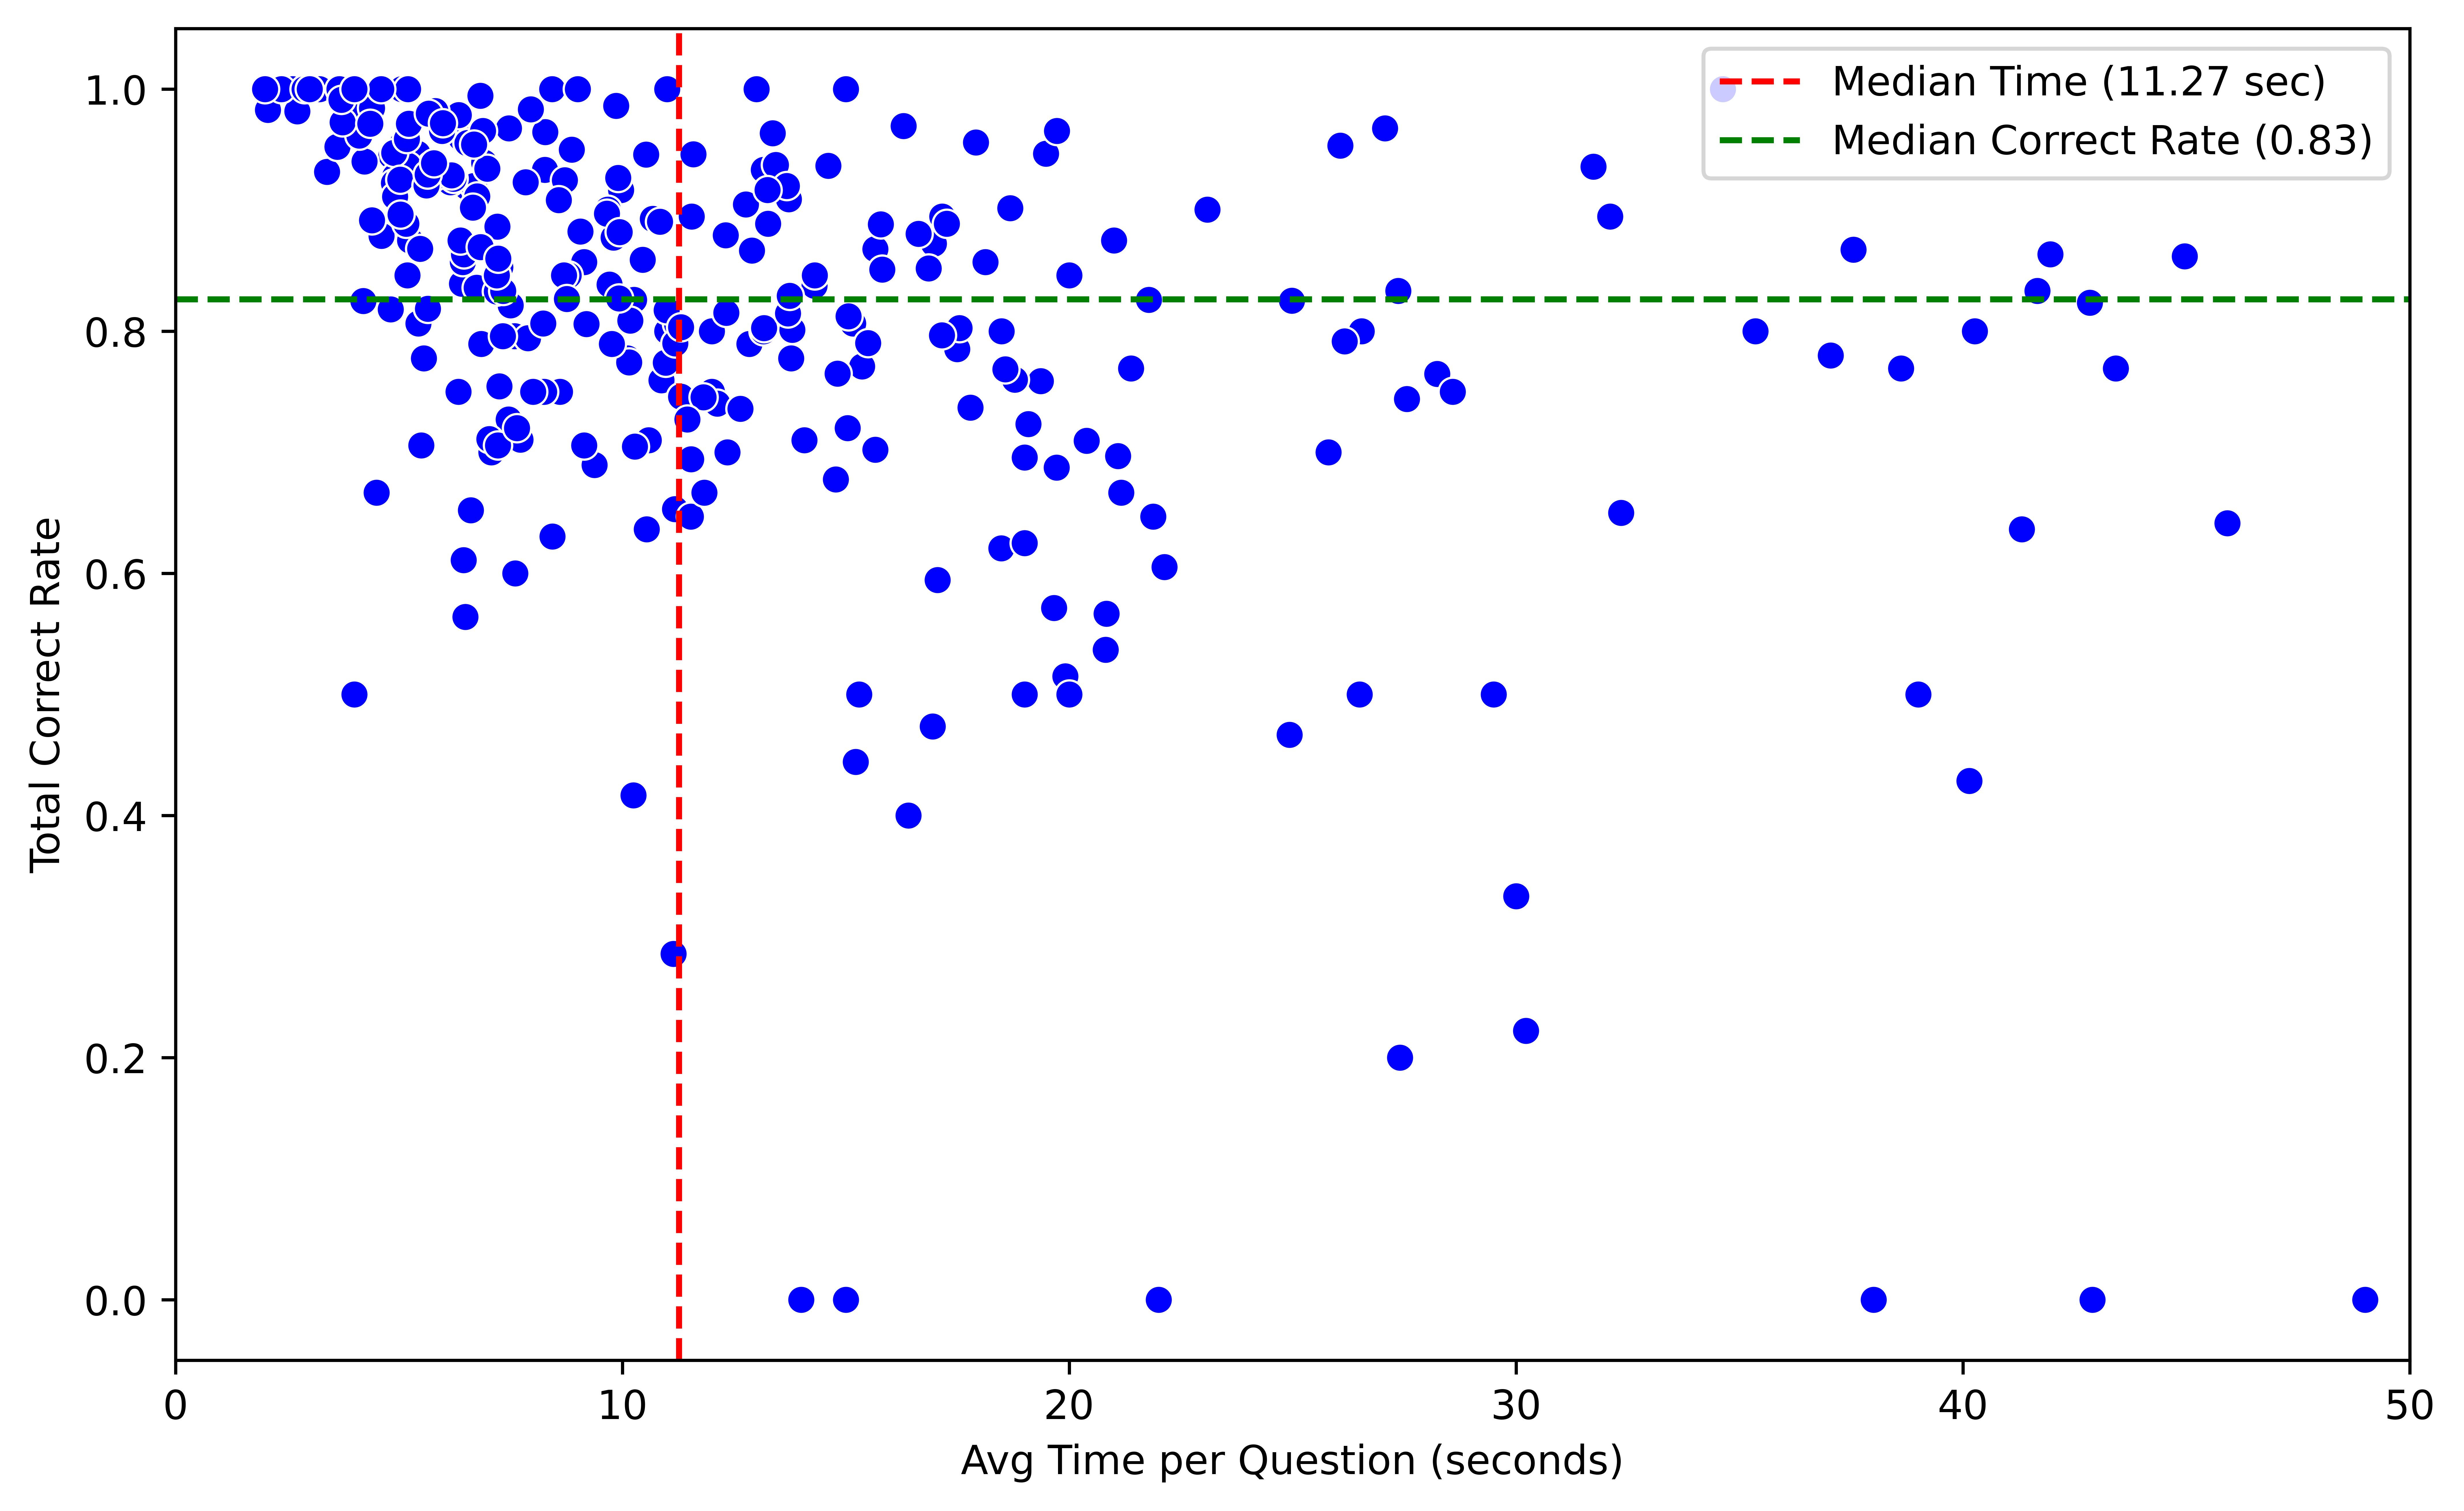

Total users: 342


In [84]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: 使用前一題的查詢，取得持續作答的使用者的作答紀錄
query = """
SELECT 
    a.AnswerID, 
    a.UserID, 
    a.QuestionID, 
    a.MissionID, 
    a.IsCorrect, 
    a.CostTime, 
    a.CreatedAt, 
    s.EndedAt 
FROM 
    answers a
JOIN 
    subscriptions s ON a.UserID = s.SubscriberID 
WHERE
    a.CreatedAt >= '2021-05-01'
And
    a.CreatedAt > s.EndedAt;
"""

# Step 2: 執行查詢並獲取結果 DataFrame
answer_records_df = duck_connection.execute(query).fetchdf()

# Step 3: 將查詢結果按照 UserID 分組，計算平均每題所花時間和總答對率
# 1. 平均每題所花時間 = CostTime 的平均值
# 2. 總答對率 = IsCorrect 的平均值 (0 或 1)

summary_df = answer_records_df.groupby('userid').agg(
    AvgTimePerQuestion=('costtime', 'mean'),  # 計算平均每題所花時間
    TotalCorrectRate=('iscorrect', 'mean')    # 計算總答對率
).reset_index()

# Step 5: 計算中位數
median_time = summary_df['AvgTimePerQuestion'].median()
median_correct_rate = summary_df['TotalCorrectRate'].median()

# Step 6: 使用 Matplotlib 和 Seaborn 繪製散佈圖
plt.figure(figsize=(10, 6), dpi=1000)
sns.scatterplot(
    data=summary_df, 
    x='AvgTimePerQuestion', 
    y='TotalCorrectRate', 
    s=50, 
    color='b'
)

# 加入中位數的垂直線和水平線
plt.axvline(median_time, color='r', linestyle='--', label=f'Median Time ({median_time:.2f} sec)')
plt.axhline(median_correct_rate, color='g', linestyle='--', label=f'Median Correct Rate ({median_correct_rate:.2f})')

# 添加標籤和標題
# plt.title('Scatter Plot of Avg Time per Question vs Total Correct Rate')
plt.xlabel('Avg Time per Question (seconds)')
plt.ylabel('Total Correct Rate')

plt.xlim(0, 50)

# 顯示圖例
plt.legend()

# 顯示圖形
plt.show()

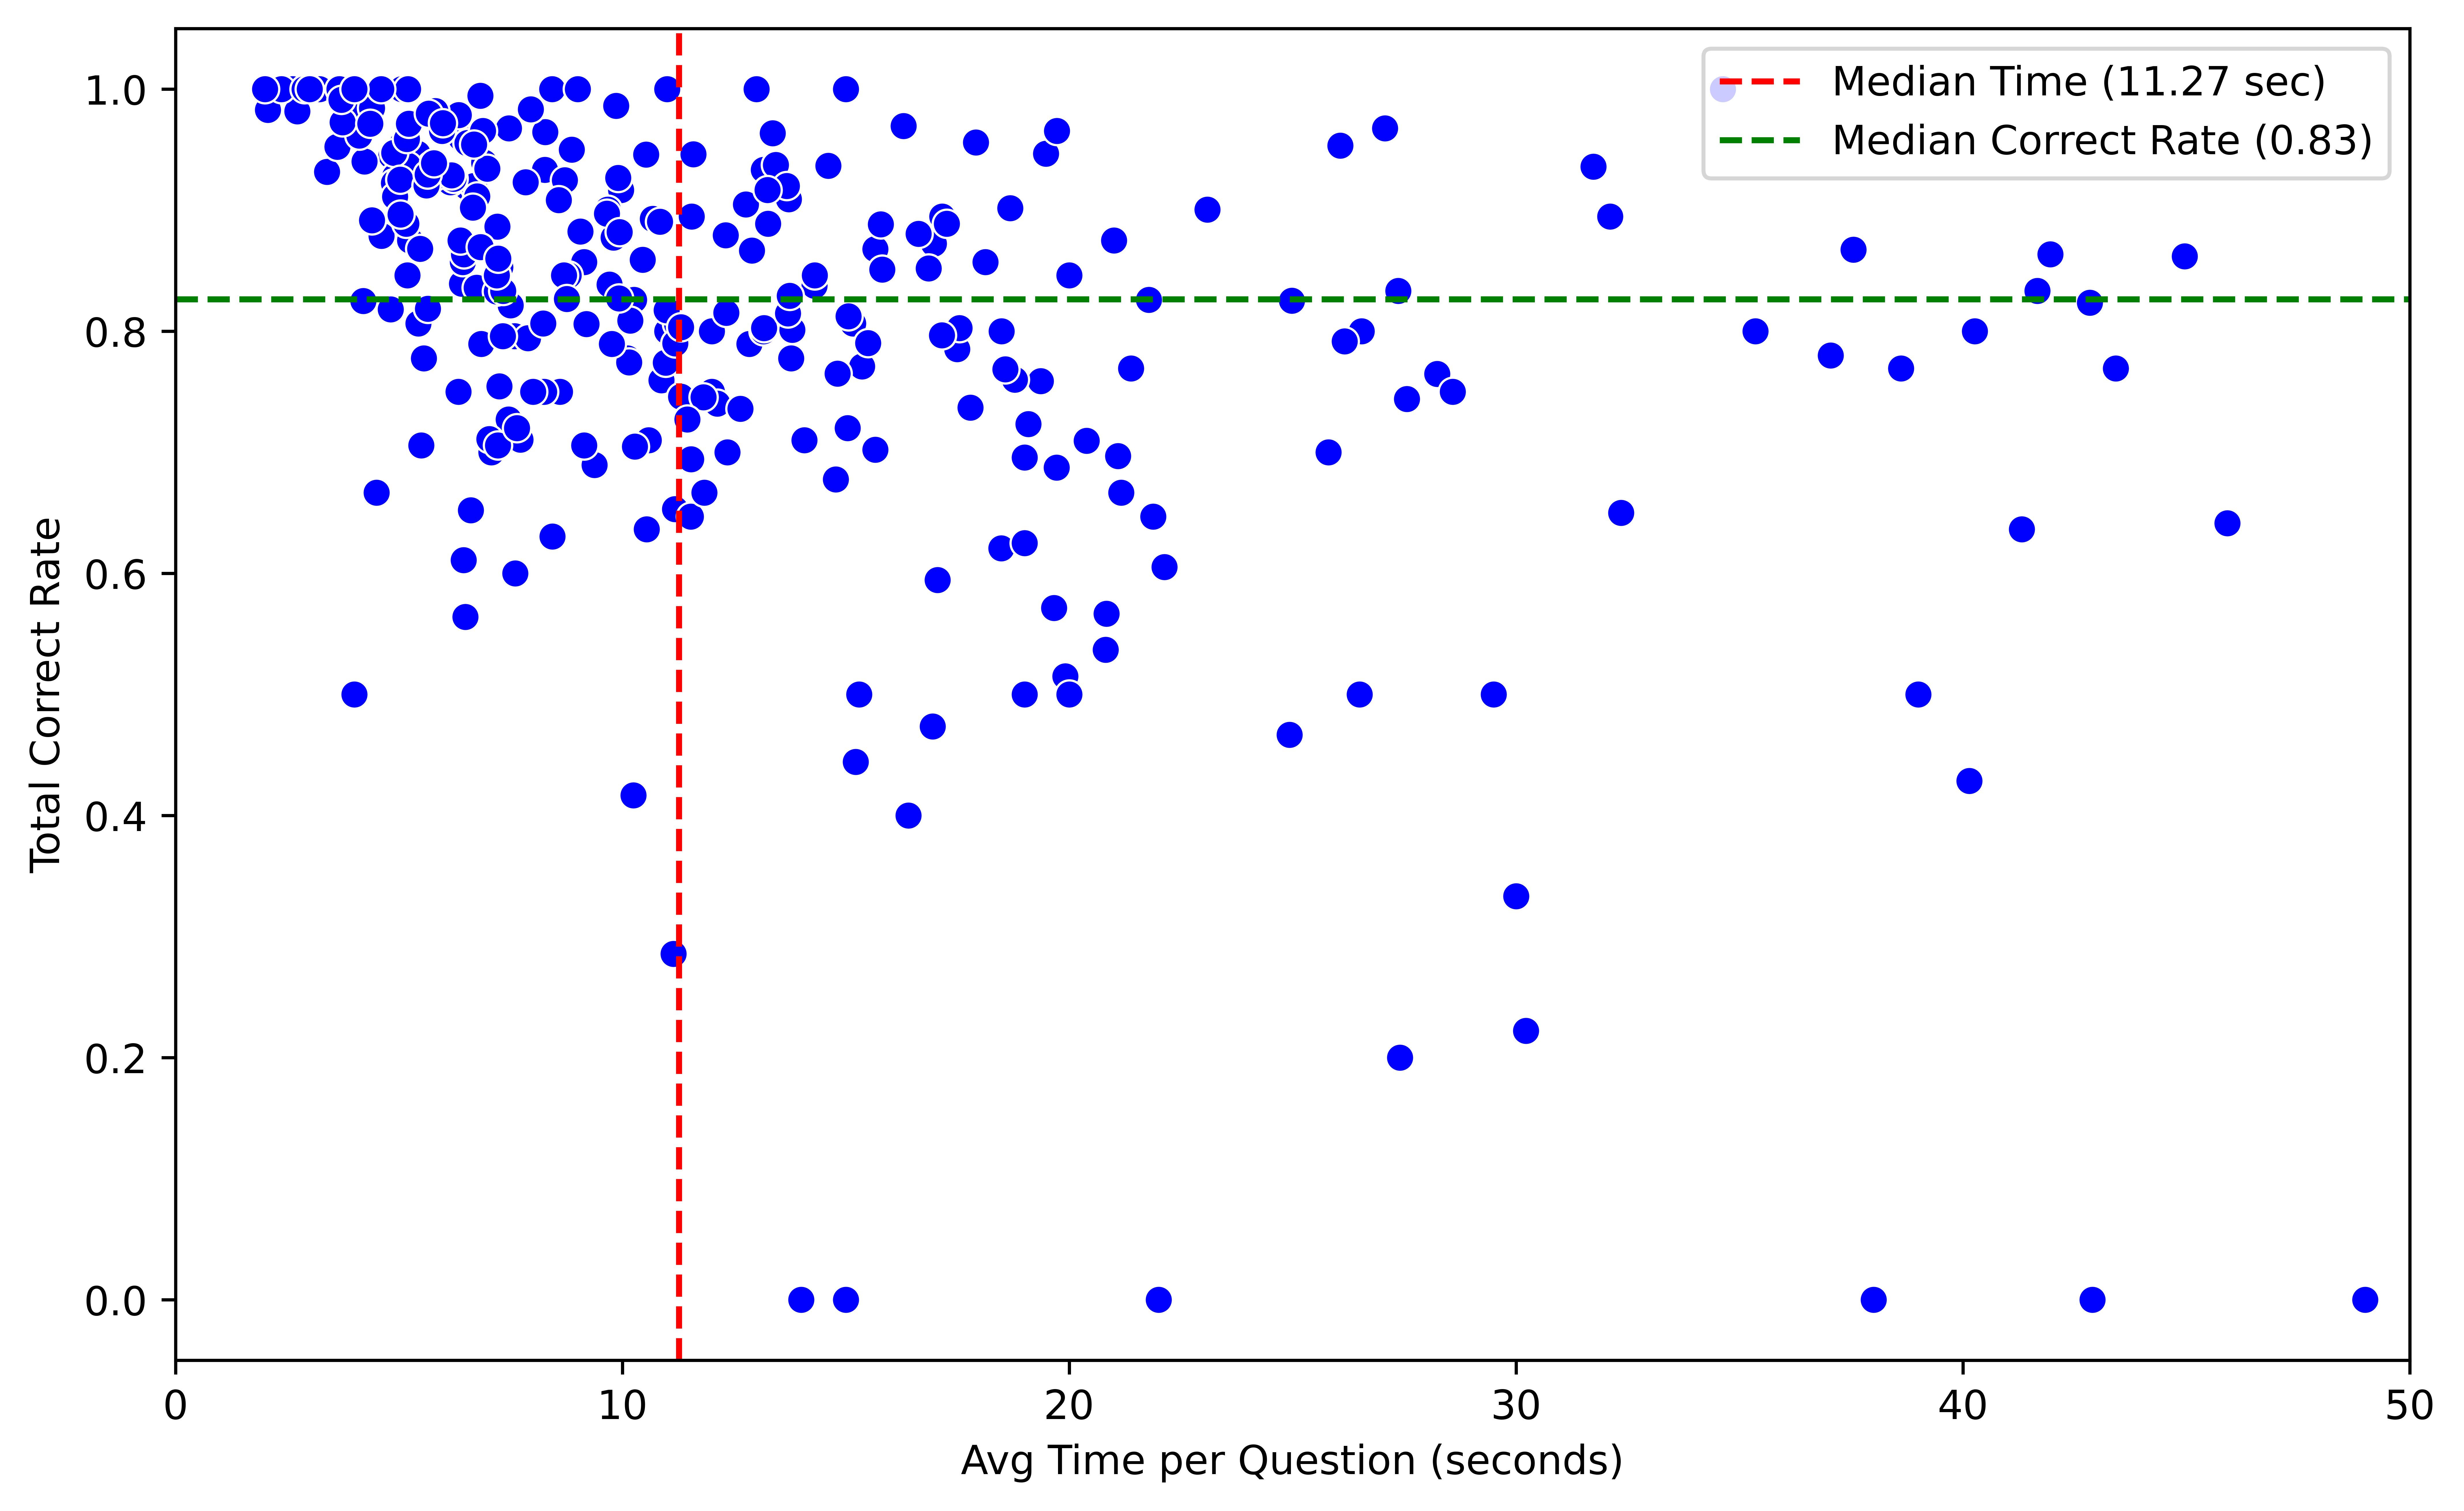

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

summary_df = result_df.groupby('userid').agg(
    AvgTimePerQuestion=('costtime', 'mean'),
    TotalCorrectRate=('iscorrect', 'mean')
).reset_index()

median_time = summary_df['AvgTimePerQuestion'].median()
median_correct_rate = summary_df['TotalCorrectRate'].median()

plt.figure(figsize=(10, 6), dpi=1000)
sns.scatterplot(
    data=summary_df, 
    x='AvgTimePerQuestion', 
    y='TotalCorrectRate', 
    s=50, 
    color='b'
)

plt.axvline(median_time, color='r', linestyle='--', label=f'Median Time ({median_time:.2f} sec)')
plt.axhline(median_correct_rate, color='g', linestyle='--', label=f'Median Correct Rate ({median_correct_rate:.2f})')

plt.xlabel('Avg Time per Question (seconds)')
plt.ylabel('Total Correct Rate')

plt.xlim(0, 50)
plt.legend()

plt.show()

In [49]:
# 檢查 answer_records_df 的欄位名稱
print(answer_records_df.columns)


Index(['answerid', 'userid', 'questionid', 'missionid', 'iscorrect',
       'costtime', 'createdat', 'endedat'],
      dtype='object')


## (c)
<font size='3'>
承第一小題。為了瞭解 Imperative Programming 和 Declarative Programming 之間的差別，我們現在想比較 Python pandas 的兩種寫法。請使用 pandas 去完成以下兩個任務：
</font>

### (i)
<font size='3'>
請寫一段程式碼依序去 (1) merge Answers 和 Subscriptions、(2) 篩選出 Answers.CreatedAt 晚於 Subscriptions.EndedAt 且 Answers.CreatedAt 不早於 2021/5/1 的作答紀錄、(3) 挑出要留下的欄位、(4) 展示前五筆結果。
</font>

In [60]:
import pandas as pd
import time

# Step 1: 讀取 CSV 檔案到 DataFrame 中
answers_df = pd.read_csv('./OnlineLearning_csv/answers.csv')
subscriptions_df = pd.read_csv('./OnlineLearning_csv/subscriptions.csv')

# 記錄開始時間
start_time = time.time()

# Step 2: 合併 Answers 和 Subscriptions 資料表 (根據 UserID 與 SubscriberID)
merged_df = pd.merge(answers_df, subscriptions_df, left_on='UserID', right_on='SubscriberID')

# Step 3: 篩選出 Answers.CreatedAt 晚於 Subscriptions.EndedAt，且 Answers.CreatedAt 不早於 2021/5/1 的作答記錄
filtered_df = merged_df[
    (merged_df['CreatedAt_x'] >= '2021-05-01') & 
    (merged_df['CreatedAt_x'] > merged_df['EndedAt'])
]

# Step 4: 挑出要留下的欄位 (AnswerID, UserID, QuestionID, MissionID, IsCorrect, CostTime, CreatedAt, EndedAt)
selected_columns = filtered_df[['AnswerID', 'UserID', 'QuestionID', 'MissionID', 'IsCorrect', 'CostTime', 'CreatedAt_x', 'EndedAt']]

# 重命名 CreatedAt_x 為 CreatedAt 以避免混淆
selected_columns.rename(columns={'CreatedAt_x': 'CreatedAt'}, inplace=True)

# Step 5: 展示前五筆結果
print(selected_columns.head())

# 記錄結束時間
end_time = time.time()

# 計算並顯示運行時間
print(f"Time taken: {end_time - start_time} seconds")


         AnswerID    UserID QuestionID MissionID  IsCorrect  CostTime  \
1184977  a3455948  u0004445   q0236673       NaN          1         5   
1184981  a3455952  u0004445   q0236085       NaN          1         4   
1184983  a3455954  u0004445   q0236032       NaN          1         8   
1184984  a3455955  u0004445   q0260118       NaN          1         3   
1184987  a3455958  u0004445   q0234539       NaN          1         3   

                   CreatedAt              EndedAt  
1184977  2021-05-01 00:00:07  2021-03-02 23:59:59  
1184981  2021-05-01 00:00:18  2021-03-02 23:59:59  
1184983  2021-05-01 00:00:30  2021-03-02 23:59:59  
1184984  2021-05-01 00:00:39  2021-03-02 23:59:59  
1184987  2021-05-01 00:00:48  2021-03-02 23:59:59  
Time taken: 0.8418700695037842 seconds


/var/folders/pk/knrkn_dn3l38qxkbzxpx06g40000gn/T/ipykernel_36266/2446559874.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns.rename(columns={'CreatedAt_x': 'CreatedAt'}, inplace=True)


### (ii)
<font size='3'>
請寫一段程式碼依序去 (1) 在 Answers 中篩選出 Answers.CreatedAt 不早於2021/5/1 的作答紀錄、(2) merge 篩選過的 Answers 和完整的 Subscriptions、(3) 篩選出 Answers.CreatedAt 晚於 Subscriptions.EndedAt 的作答紀錄、(4)
挑出要留下的欄位、(5) 展示前五筆結果。
</font>

In [70]:
import pandas as pd
import time

# Step 1: 讀取 CSV 檔案到 DataFrame 中
answers_df = pd.read_csv('./OnlineLearning_csv/answers.csv')
subscriptions_df = pd.read_csv('./OnlineLearning_csv/subscriptions.csv')

# 記錄開始時間
start_time = time.time()

# Step 1: 在 Answers 中篩選出 CreatedAt 不早於 2021/5/1 的作答記錄
filtered_answers_df = answers_df[answers_df['CreatedAt'] >= '2021-05-01']

# Step 2: 合併篩選過的 Answers 和完整的 Subscriptions (根據 UserID 和 SubscriberID)
merged_df = pd.merge(filtered_answers_df, subscriptions_df, left_on='UserID', right_on='SubscriberID')

# Step 3: 篩選出 Answers.CreatedAt 晚於 Subscriptions.EndedAt 的作答記錄
final_filtered_df = merged_df[merged_df['CreatedAt_x'] > merged_df['EndedAt']]


# Step 4: 挑出要留下的欄位 (AnswerID, UserID, QuestionID, MissionID, IsCorrect, CostTime, CreatedAt, EndedAt)
selected_columns = final_filtered_df[['AnswerID', 'UserID', 'QuestionID', 'MissionID', 'IsCorrect', 'CostTime', 'CreatedAt_x', 'EndedAt']]

# 重命名 CreatedAt_x 為 CreatedAt 以避免混淆
selected_columns.rename(columns={'CreatedAt_x': 'CreatedAt'}, inplace=True)

# Step 5: 展示前五筆結果
print(selected_columns.head())

# 記錄結束時間
end_time = time.time()

# 計算並顯示運行時間
print(f"Time taken: {end_time - start_time} seconds")

    AnswerID    UserID QuestionID MissionID  IsCorrect  CostTime  \
2   a3455948  u0004445   q0236673       NaN          1         5   
6   a3455952  u0004445   q0236085       NaN          1         4   
8   a3455954  u0004445   q0236032       NaN          1         8   
9   a3455955  u0004445   q0260118       NaN          1         3   
12  a3455958  u0004445   q0234539       NaN          1         3   

              CreatedAt              EndedAt  
2   2021-05-01 00:00:07  2021-03-02 23:59:59  
6   2021-05-01 00:00:18  2021-03-02 23:59:59  
8   2021-05-01 00:00:30  2021-03-02 23:59:59  
9   2021-05-01 00:00:39  2021-03-02 23:59:59  
12  2021-05-01 00:00:48  2021-03-02 23:59:59  
Time taken: 0.1497800350189209 seconds


/var/folders/pk/knrkn_dn3l38qxkbzxpx06g40000gn/T/ipykernel_36266/1651864337.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns.rename(columns={'CreatedAt_x': 'CreatedAt'}, inplace=True)
